# Geographic Manipulations Part III #

I'm going to map the accident clusters, and determine if I need to create empty spaces with no accidents. First some sanity checks.

In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import shapely.wkt as wkt
import math
from shapely.geometry import Point, LineString, Polygon
from matplotlib import pyplot as plt

In [2]:
# Read in accident clusters
cl_df = pd.read_csv('data/cleaned_data/acc_clusters.csv')

# Fill NA values
cl_df = cl_df.fillna('')

# convert shape strings back to shapes
cl_df['shape'] = cl_df['shape'].map(lambda a: wkt.loads(a))

#convert buffer strings back to shapes
cl_df['buffer'] = cl_df['buffer'].map(lambda a: wkt.loads(a))

#convert strings to lists
cl_df['bike_acc_ids'] = cl_df.bike_acc_ids.map(lambda a: a[1:-1].split(','))
cl_df['car_acc_ids'] = cl_df.car_acc_ids.map(lambda a: a[1:-1].split(','))

#score each region for bike and car accidents
cl_df['car_acc_score'] = cl_df['car_acc_ids'].map(lambda a: 0 if (a == '') else len(a))
cl_df['bike_acc_score'] = cl_df['bike_acc_ids'].map(lambda a: 0 if (a == '') else len(a))

Let's look at some histograms for a sanity check.

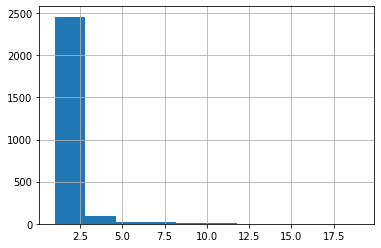

In [3]:
cl_df['bike_acc_score'].hist()

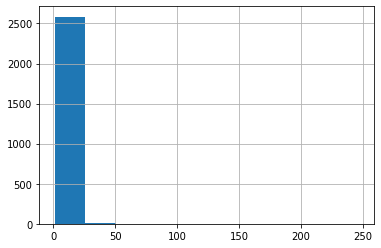

In [4]:
cl_df['car_acc_score'].hist()

In [5]:
print('Max number of bike accidents: ' + str(cl_df['bike_acc_score'].max()))
print('Max number of car accidents: ' + str(cl_df['car_acc_score'].max()))

Max number of bike accidents: 19
Max number of car accidents: 247


In [6]:
cl_df[cl_df['car_acc_score'] == 247][['shape','car_acc_ids']]

shape  \
1004  LINESTRING (236779.7876579253 896875.226466359...   

                                            car_acc_ids  
1004  ['A-194469',  'A-194920',  'A-195841',  'A-196...

Text(0.5, 1.0, 'Most car accidents')

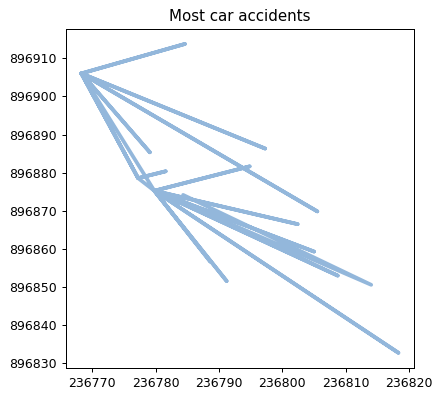

In [7]:
x,y = cl_df.iloc[1004]['shape'].coords.xy
fig = plt.figure(1, figsize=(5,5), dpi=90)
ax = fig.add_subplot(111)
ax.plot(x, y, color='#6699cc', alpha=0.7, linewidth=3, solid_capstyle='round', zorder=2)
ax.set_title('Most car accidents')

In [8]:
cl_gdf = gpd.GeoDataFrame(cl_df).set_geometry('buffer')
cl_gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 2611 entries, 0 to 2610
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   Unnamed: 0      2611 non-null   int64   
 1   Unnamed: 0.1    2611 non-null   object  
 2   shape           2611 non-null   object  
 3   bike_acc_ids    2611 non-null   object  
 4   buffer          2611 non-null   geometry
 5   car_acc_ids     2611 non-null   object  
 6   car_acc_score   2611 non-null   int64   
 7   bike_acc_score  2611 non-null   int64   
dtypes: geometry(1), int64(3), object(4)
memory usage: 163.3+ KB


Now I want to map all my clusters and see if there are big gaps where I should create new blobs that contain places where no accidents took place.

In [9]:
big_blob = cl_gdf['buffer'].unary_union
big_blob

Yes, there are definitely areas without accidents that should have their own clusters made and added to the cluster list. 

In [20]:
#read in boston roads
rd_df = pd.read_csv('data/cleaned_data/boston_roads_gpd.csv', dtype={'StationID': 'str'})

In [21]:
rd_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34049 entries, 0 to 34048
Data columns (total 72 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Unnamed: 0       34049 non-null  int64  
 1   Route_ID         34049 non-null  object 
 2   From_Measure     34049 non-null  float64
 3   To_Measure       34049 non-null  float64
 4   Route_System     34049 non-null  object 
 5   Route_Number     34049 non-null  object 
 6   Route_Direction  32659 non-null  object 
 7   Rd_Seg_ID        13195 non-null  float64
 8   Facility         29161 non-null  float64
 9   Mile_Count       29154 non-null  float64
 10  F_Class          33369 non-null  float64
 11  Urban_Area       33368 non-null  float64
 12  Urban_Type       33368 non-null  float64
 13  F_F_Class        33369 non-null  float64
 14  Jurisdictn       33152 non-null  object 
 15  NHS              33324 non-null  float64
 16  Fd_Aid_Rd        13122 non-null  float64
 17  Control     

Now I need the road information for the accident clusters, with the road information for places with no accidents.

In [22]:
#convert road geometry column into shapes
rd_df['geometry'] = rd_df['geometry'].map(lambda a: wkt.loads(a))
rd_df['road_shape'] = rd_df['road_shape'].map(lambda a: wkt.loads(a))

In [23]:
#create geo dataframe out of road dataframe
rd_gdf = gpd.GeoDataFrame(rd_df)
rd_gdf.head()

Unnamed: 0    Route_ID  From_Measure  To_Measure Route_System Route_Number  \
0           0     N131 EB  3.181055e-01    0.391236            N          131   
1           1  L189566 EB  8.960668e-02    0.166071            L       189566   
2           2  L234604 NB -3.000000e-08    0.041151            L       234604   
3           3    N2558 SB  6.729626e-02    0.113344            N         2558   
4           4     N126 NB -3.000000e-08    0.048191            N          126   

  Route_Direction  Rd_Seg_ID  Facility  Mile_Count  ...  City_Maint     AADT  \
0              EB    44813.0       1.0         1.0  ...        35.0  15848.0   
1              EB        NaN       1.0         1.0  ...        35.0   1154.0   
2              NB        NaN       NaN         NaN  ...        35.0      NaN   
3              SB    57875.0       1.0         1.0  ...        35.0   3879.0   
4              NB    56520.0       1.0         1.0  ...        35.0   9643.0   

   AADT_Year  AADT_Deriv Statn_Num  StationID    Length  Shape_Length  \
0     2017.0        14.0       NaN        NaN  0.073130    118.262573   
1        NaN         NaN       NaN        NaN  0.076465    123.058391   
2        NaN         NaN       NaN        NaN  0.041151     66.226149   
3     2017.0        14.0       NaN        NaN  0.046048     72.938788   
4     2017.0        14.0       NaN        NaN  0.048191     71.256196   

                                          road_shape  \
0  (LINESTRING Z (235874.8973999992 900298.458399...   
1  (LINESTRING Z (236191.3762999997 900388.962499...   
2  (LINESTRING Z (236493.2151999995 900333.206799...   
3  (LINESTRING Z (236298.6516000032 900406.841600...   
4  (LINESTRING Z (236560.2012000009 900362.371300...   

                                            geometry  
0  POLYGON ((235836.651 900360.482, 235842.111 90...  
1  POLYGON ((236287.600 900385.071, 236297.148 90...  
2  POLYGON ((236449.522 900403.753, 236450.213 90...  
3  POLYGON ((236343.958 900385.811, 236348.186 90...  
4  POLYGON ((236502.411 900338.971, 236499.093 90...  

[5 rows x 72 columns]

In [25]:
#set the correct column to be the geometry column
cl_gdf = gpd.GeoDataFrame(cl_df).set_geometry('buffer')

In [26]:
rd_gdf = rd_gdf.set_geometry('geometry')

In [27]:
cl_intersect = gpd.overlay(cl_gdf, rd_gdf, how='intersection')

In [28]:
cl_intersect.info(verbose=True, null_counts=True)

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 40229 entries, 0 to 40228
Data columns (total 79 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   Unnamed: 0_1     40229 non-null  int64   
 1   Unnamed: 0.1     40229 non-null  object  
 2   shape            40229 non-null  object  
 3   bike_acc_ids     40229 non-null  object  
 4   car_acc_ids      40229 non-null  object  
 5   car_acc_score    40229 non-null  int64   
 6   bike_acc_score   40229 non-null  int64   
 7   Unnamed: 0_2     40229 non-null  int64   
 8   Route_ID         40229 non-null  object  
 9   From_Measure     40229 non-null  float64 
 10  To_Measure       40229 non-null  float64 
 11  Route_System     40229 non-null  object  
 12  Route_Number     40229 non-null  object  
 13  Route_Direction  36325 non-null  object  
 14  Rd_Seg_ID        22969 non-null  float64 
 15  Facility         36729 non-null  float64 
 16  Mile_Count       36712 non-null 

Now I need too create a database of road areas without accicents

In [29]:
# get the geometries that are a part of rd_gdf but not cl_gdf

cl_difference = gpd.overlay(rd_gdf, cl_gdf, how='difference')
cl_difference.head()

Unnamed: 0    Route_ID  From_Measure  To_Measure Route_System Route_Number  \
0           0     N131 EB  3.181055e-01    0.391236            N          131   
1           1  L189566 EB  8.960668e-02    0.166071            L       189566   
2           2  L234604 NB -3.000000e-08    0.041151            L       234604   
3           3    N2558 SB  6.729626e-02    0.113344            N         2558   
4           4     N126 NB -3.000000e-08    0.048191            N          126   

  Route_Direction  Rd_Seg_ID  Facility  Mile_Count  ...  City_Maint     AADT  \
0              EB    44813.0       1.0         1.0  ...        35.0  15848.0   
1              EB        NaN       1.0         1.0  ...        35.0   1154.0   
2              NB        NaN       NaN         NaN  ...        35.0      NaN   
3              SB    57875.0       1.0         1.0  ...        35.0   3879.0   
4              NB    56520.0       1.0         1.0  ...        35.0   9643.0   

   AADT_Year  AADT_Deriv Statn_Num  StationID    Length  Shape_Length  \
0     2017.0        14.0       NaN        NaN  0.073130    118.262573   
1        NaN         NaN       NaN        NaN  0.076465    123.058391   
2        NaN         NaN       NaN        NaN  0.041151     66.226149   
3     2017.0        14.0       NaN        NaN  0.046048     72.938788   
4     2017.0        14.0       NaN        NaN  0.048191     71.256196   

                                          road_shape  \
0  (LINESTRING Z (235874.8973999992 900298.458399...   
1  (LINESTRING Z (236191.3762999997 900388.962499...   
2  (LINESTRING Z (236493.2151999995 900333.206799...   
3  (LINESTRING Z (236298.6516000032 900406.841600...   
4  (LINESTRING Z (236560.2012000009 900362.371300...   

                                            geometry  
0  POLYGON ((235836.651 900360.482, 235842.111 90...  
1  MULTIPOLYGON (((236287.600 900385.071, 236297....  
2  MULTIPOLYGON (((236505.514 900341.950, 236505....  
3  POLYGON ((236343.958 900385.811, 236348.186 90...  
4  POLYGON ((236502.411 900338.971, 236501.819 90...  

[5 rows x 72 columns]

In [30]:
#output intersect and difference files for later reference
cl_intersect.to_csv(r'data/cleaned_data/cl_intersect.csv')
cl_difference.to_csv(r'data/cleaned_data/cl_difference.csv')

I think the last thing I need to do is append the cl_difference to the cl_intersect dataframe and add zero columns for bike and accident score.

In [31]:
#rename cl_difference geometry columns so the append works more smoothly
cl_difference = cl_difference.rename(columns={'geometry': 'road_line', 'buffer': 'geometry'})

#append the two dataframes together
agg_gdf = cl_intersect.append(cl_difference)
len(agg_gdf)

74122

In [32]:
agg_gdf.info(verbose=True, null_counts=True)

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 74122 entries, 0 to 34048
Data columns (total 81 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   Unnamed: 0_1     40229 non-null  float64 
 1   Unnamed: 0.1     40229 non-null  object  
 2   shape            40229 non-null  object  
 3   bike_acc_ids     40229 non-null  object  
 4   car_acc_ids      40229 non-null  object  
 5   car_acc_score    40229 non-null  float64 
 6   bike_acc_score   40229 non-null  float64 
 7   Unnamed: 0_2     40229 non-null  float64 
 8   Route_ID         74122 non-null  object  
 9   From_Measure     74122 non-null  float64 
 10  To_Measure       74122 non-null  float64 
 11  Route_System     74122 non-null  object  
 12  Route_Number     74122 non-null  object  
 13  Route_Direction  68855 non-null  object  
 14  Rd_Seg_ID        36019 non-null  float64 
 15  Facility         65737 non-null  float64 
 16  Mile_Count       65714 non-null 

In [33]:
agg_gdf = agg_gdf.set_geometry('geometry')

In [34]:
#fill in accident scores
agg_gdf = agg_gdf.fillna({'bike_acc_score': 0, 'car_acc_score': 0})

In [35]:
agg_gdf.info(verbose=True, null_counts=True)

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 74122 entries, 0 to 34048
Data columns (total 81 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   Unnamed: 0_1     40229 non-null  float64 
 1   Unnamed: 0.1     40229 non-null  object  
 2   shape            40229 non-null  object  
 3   bike_acc_ids     40229 non-null  object  
 4   car_acc_ids      40229 non-null  object  
 5   car_acc_score    74122 non-null  float64 
 6   bike_acc_score   74122 non-null  float64 
 7   Unnamed: 0_2     40229 non-null  float64 
 8   Route_ID         74122 non-null  object  
 9   From_Measure     74122 non-null  float64 
 10  To_Measure       74122 non-null  float64 
 11  Route_System     74122 non-null  object  
 12  Route_Number     74122 non-null  object  
 13  Route_Direction  68855 non-null  object  
 14  Rd_Seg_ID        36019 non-null  float64 
 15  Facility         65737 non-null  float64 
 16  Mile_Count       65714 non-null 

In [36]:
agg_gdf.to_csv(r'data/cleaned_data/agg_clusters.csv')